<img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png" width="300" height="300" align="center"/><br>

Welcome to another JAX tutorial. I hope you all have been enjoying the JAX Tutorials so far. If you haven't gone through the previous tutorials, I highly suggest going through them. Here are the links:

1. [TF_JAX_Tutorials - Part 1](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part1)
2. [TF_JAX_Tutorials - Part 2](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part2)
3. [TF_JAX_Tutorials - Part 3](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part3)
4. [TF_JAX_Tutorials - Part 4 (JAX and DeviceArray)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-4-jax-and-devicearray)
5. [TF_JAX_Tutorials - Part 5 (Pure Functions in JAX)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-5-pure-functions-in-jax/)
6. [TF_JAX_Tutorials - Part 6 (PRNG in JAX)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-6-prng-in-jax/)
7. [TF_JAX_Tutorials - Part 7 (JIT in JAX)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-7-jit-in-jax)
8. [TF_JAX_Tutorials - Part 8 (Vmap and Pmap)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-8-vmap-pmap)
9. [TF_JAX_Tutorials - Part 9 (Autodiff in JAX)](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-9-autodiff-in-jax)


We are going to cover an important concept that is very specific to JAX, and not to other libraries. Also, this notebook is the last notbook that will be wrap up the fundamentals or the building blocks of JAX. If you have gone through all the other tutorials already, I am hoping that you know have a very solid understanding of how JAX works under the hood. Understanding the fundamnetals is the key to learn anything in a solid way. Without any further due, let's start!

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from jax import make_jaxpr
from jax import vmap, pmap, jit
from jax import grad, value_and_grad
from jax.test_util import check_grads


%config IPCompleter.use_jedi = False

# Pytrees

What is a Pytree? If we go by the definition of Pytress as provided in the [docs](https://jax.readthedocs.io/en/latest/pytrees.html), then a *pytree* refers to a tree-like structure built out of container-like Python objects.

What are the container-like Python objects? Given the name, you might have already guessed that the container-like Python objects include **list**, **tuples**, **dictionaries**, **namedtuple**, **OrderedDict**, and **None** (this isn't so obvious). These data structures are the default container-like objects treated as Pytrees. We can also tell JAX to treat a class as a container-like object but we need to include them in pytree registry first (We will discuss this in detail later on in this tutorial).

Let's take a look at a few examples of Pytrees.

In [2]:
# A list as a pytree
example_1 = [1, 2, 3]

# As in normal Python code, a list that represents pytree
# can contain obejcts of any type
example_2 = [1, 2, "a", "b", (3, 4)]

# Similarly we can define pytree using a tuple as well
example_3 = (1, 2, "a", "b", (3, 4))

# We can define the same pytree using a dict as well
example_4 = {"k1": 1, "k2": 2, "k3": "a", "k4": "b", "k5": (3, 4)}

# Let's check the number of leaves and the corresponding values in the above pytrees
example_pytrees = [example_1, example_2, example_3, example_4]
for pytree in example_pytrees:
    leaves = jax.tree_leaves(pytree)
    print(f"Pytree: {repr(pytree):<30}")
    print(f"Number of leaves: {len(leaves)}")
    print(f"Leaves are: {leaves}\n")
    print("="*50)

Pytree: [1, 2, 3]                     
Number of leaves: 3
Leaves are: [1, 2, 3]

Pytree: [1, 2, 'a', 'b', (3, 4)]      
Number of leaves: 6
Leaves are: [1, 2, 'a', 'b', 3, 4]

Pytree: (1, 2, 'a', 'b', (3, 4))      
Number of leaves: 6
Leaves are: [1, 2, 'a', 'b', 3, 4]

Pytree: {'k1': 1, 'k2': 2, 'k3': 'a', 'k4': 'b', 'k5': (3, 4)}
Number of leaves: 6
Leaves are: [1, 2, 'a', 'b', 3, 4]



So, in short, a pytree is just a composition of **nodes**(container-like Python objects) and **leaves**(all other Python objects). JAX also lets you register custom types as pytrees (we will take a few examples of this later on)

One question that you should be asking at this point is whether a **DeviceArray**, the core data structure in JAX, can be used as a pytree or not. Well, the answer is no. Any *ndarray* is treated as a leaf in a pytree/ Let's take an example to make it clear.

In [3]:
# Check if we can make a pytree from a DeviceArray
example_5 = jnp.array([1, 2, 3])
leaves = jax.tree_leaves(example_5)
print(f"DeviceArray: {repr(example_5):<30}")
print(f"Number of leaves: {len(leaves)}")
print(f"Leaves are: {leaves}")

DeviceArray: DeviceArray([1, 2, 3], dtype=int32)
Number of leaves: 1
Leaves are: [DeviceArray([1, 2, 3], dtype=int32)]


As you can see, the ndarray is considered as one leaf only. The same goes for numeric values.

Another important thing to note is that pytrees are tree-like data structures rather than DAG-like or graph-like. They assume referential transparency, and that there are no reference cycles present. So, don't use the same object in multiple leaves of a pytree

We can *flatten* the tree at each level, get the leaves, and the original tree structure as well. Let's see it in action

In [4]:
# We will use the `example_2` pytree for this purpose.
# Our pytree looks like this: [1, 2, 'a', 'b', (3, 4)]
# We will unflatten it, obtain the leaves, and the tree structure as well

example_2_leaves, example_2_treedef = jax.tree_flatten(example_2)
print(f"Original Pytree: {repr(example_2)}")
print(f"Leaves: {repr(example_2_leaves)}")
print(f"Pytree structure: {repr(example_2_treedef)}")

Original Pytree: [1, 2, 'a', 'b', (3, 4)]
Leaves: [1, 2, 'a', 'b', 3, 4]
Pytree structure: PyTreeDef([*, *, *, *, (*, *)])


Now that we have extracted the leaves, we can modify these and reconstruct the tree again using the original tree structure (treedef). 

**Note:** We can(should) use `tree_map(...)` and `tree_multimap(...)` for doing operations on leaves as it is a much better way to achieve it. The above example is to showcase that you can do it in a way where you want more control over the operations applied to different leaves of the tree

In [5]:
def change_even_positioned_leaf(x, pos):
    if pos % 2 == 0:
        return x * 2
    else:
        return x
    
transformed_leaves = [
    change_even_positioned_leaf(leaf, pos+1) for pos, leaf in enumerate(example_2_leaves)
]

print(f"Original leaves:    {repr(example_2_leaves)}")
print(f"Transformed leaves: {repr(transformed_leaves)}")

Original leaves:    [1, 2, 'a', 'b', 3, 4]
Transformed leaves: [1, 4, 'a', 'bb', 3, 8]


We can now use the original tree structure to rebuild the tree with the transformed leaves

In [6]:
# Reconstruct the tree
example_2_modified = jax.tree_unflatten(treedef=example_2_treedef, leaves=transformed_leaves)
print(f"Original Pytree:    {repr(example_2)}")
print(f"Transformed Pytree: {repr(example_2_modified)}")

Original Pytree:    [1, 2, 'a', 'b', (3, 4)]
Transformed Pytree: [1, 4, 'a', 'bb', (3, 8)]


We saw that Pytree are container-like Python objects like lists, tuples, dicts, etc. But what if you want to extend this set of Python objects treated as pytree nodes? For example, what if you want to treat your class as a Pytree node? 

Well, if you think about it, to treat a class as a pytree node, we need to:
1. Tell JAX that you want to treat it as a node and not a leaf by registering it in the internal registry.
2. Because this is a custom object, JAX doesn't know how to `flatten` and `unflatten` it, we need to tell JAX this as well
3. There are cases when we need to compare two `treedef` structures for equality. Hence we need to make sure that adding a custom object doesn't break the equality check.

Let's look at an example.

In [7]:
from jax.tree_util import register_pytree_node
from jax.tree_util import register_pytree_node_class

In [8]:
class Counter:
    def __init__(self, count, name):
        self.count = count
        self.name = name
        
    def __repr__(self):
        return f"Counter value = {self.count}"
    
    def increment(self):
        return self.count + 1
    
    def decrement(self):
        return self.count - 1
    

# Because JAX doesn't know how to flattent and unflatten these custom objects
# hence we need to define those methods for these objects

def flatten_counter(tree):
    """Specifies how to flatten a Counter class object.
    
    Args:
        tree: Counter class object represented as Pytree node
    Returns:
        A pair of an iterable with the children to be flattened recursively,
        and some opaque auxiliary data to pass back to the unflattening recipe.
        The auxiliary data is stored in the treedef for use during unflattening.
        The auxiliary data could be used, e.g., for dictionary keys.
    """
    
    children = (tree.count,)
    aux_data = tree.name # We don't want to treat the name as a child
    return (children, aux_data)


def unflatten_counter(aux_data, children):
    """Specifies how to unflattening a Counter class object.

    Args:
        aux_data: the opaque data that was specified during flattening of the
            current treedef.
        children: the unflattened children
    Returns:
        A re-constructed object of the registered type, using the specified
        children and auxiliary data.
    """
    return Counter(*children, aux_data)


# Now all we need to do is to tell JAX that we need to Register our class as
# a Pytree node and it need to treat all the objects of that class as such
register_pytree_node(
    Counter,
    flatten_counter,    # tell JAX what are the children nodes
    unflatten_counter   # tell JAX how to pack back into a `Counter`
)

In [9]:
# An instance of the Counter class
my_counter = Counter(count=5, name="Counter_class_as_pytree_node")

# Flatten the custom object
my_counter_leaves, my_counter_treedef = jax.tree_flatten(my_counter)

# Unflatten
my_counter_reconstructed = jax.tree_unflatten(
    treedef=my_counter_treedef, leaves=my_counter_leaves
)
print(f"Original Pytree: {repr(my_counter)}")
print(f"Leaves: {repr(my_counter_leaves)}")
print(f"Pytree structure: {repr(my_counter_treedef)}")
print(f"Reconstructed Pytree: {repr(my_counter_reconstructed)}")

Original Pytree: Counter value = 5
Leaves: [5]
Pytree structure: PyTreeDef(CustomNode(<class '__main__.Counter'>[Counter_class_as_pytree_node], [*]))
Reconstructed Pytree: Counter value = 5


Easy, right? Well, that's JAX is all about, making things easy!

**Note:** When defining a function to flatten the custom objects, please recheck the order of arguments passed to that function. The first positional parameter always represents the *auxiliary* data while the second argument always represents the *children*. Please check the `flatten_counter(...)` above as an example.

One thing that we haven't checked yet is that if our pytree can do the equality check. Let's check it.

In [10]:
# Another instance
my_counter_2 = Counter(count=5, name="Counter_class_as_pytree_node")

# Flatten the custom object
my_counter_2_leaves, my_counter_2_treedef = jax.tree_flatten(my_counter)

# Check if the treedef are same for both the pytrees
my_counter_treedef == my_counter_2_treedef

True

# Pytrees and JAX transformations

Till now we discussed what pytrees are and how can you create one, including using a custom container-like object. Before we jump onto using pytrees for some high-level examples, let's take a step back and understand how JAX function transformations like `grad`, `vmap`, etc can be applied to pytrees.

In [11]:
def activate(x):
    """Applies tanh activation."""
    return jnp.tanh(x["weights"])


# Always use the PRNG
key = random.PRNGKey(1234)
example_pytree = {"weights": random.normal(key=key, shape=(5,))}

# We will now use vmap and grad to compute the gradients per sample
grads_example_pytree = vmap(grad(activate), in_axes=({"weights":0},))(example_pytree)

print("Original pytree:")
print(f" {repr(example_pytree)}\n")
print("Leaves in the pytree:")
print(f"{repr(jax.tree_leaves(example_pytree))}\n")
print("Gradients per example:")
print(f"{grads_example_pytree}\n")

Original pytree:
 {'weights': DeviceArray([ 0.90665466, -0.9453377 ,  0.08205649, -1.8436366 ,
              0.45950893], dtype=float32)}

Leaves in the pytree:
[DeviceArray([ 0.90665466, -0.9453377 ,  0.08205649, -1.8436366 ,
              0.45950893], dtype=float32)]

Gradients per example:
{'weights': DeviceArray([0.48228705, 0.45585024, 0.99329686, 0.0953269 , 0.8153717 ],            dtype=float32)}



A few things to note:
1. We can combine any JAX transformation and apply it to the pytrees.
2. Some transformations like `vmap` and `pmap` take in optional parameters like `in_axes` and `out_axes` that specify how certain input or output values should be treated. These parameters can also be pytrees, and their structure must correspond to the pytree structure of the corresponding arguments. For example, check how we passed the value for `in_axes` in the above example

# Jaxprs and Pytrees

As with any other JAX code, you can use jaxprs with pytrees as well. For example, let's check the jaxpr of the above example

In [12]:
make_jaxpr(vmap(grad(activate), in_axes=({"weights":0},)))(example_pytree)

{ lambda  ; a.
  let b = tanh a
      c = sub 1.0 b
      d = mul 1.0 c
      e = mul d b
      f = add_any d e
  in (f,) }

# Why pytrees?

Till now we discussed Pytrees but one question that we didn't answer yet is why should you learn about pytrees and what are the common use cases for using pytrees. Although there are many use-cases for pytrees, the most common use-case is to specify the model parameters. For example, if you want to build a DNN, you can store the weights and biases corresponding to each layer as pytrees. You can even define your whole module representing the functionality of your DNN as a pytree.
Let's see an example in action for the same. This one is taken from the JAX docs only.

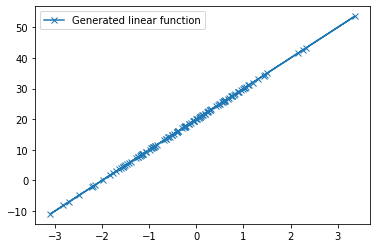

In [13]:
key = random.PRNGKey(111)
key, subkey = random.split(key)

# Generate some random data
x = random.normal(key=key, shape=(128, 1))
# Let's just do y = 10x + 20
y = 10 * x + 20

plt.plot(x, y, marker='x', label='Generated linear function')
plt.legend()
plt.show()

In [14]:
def initialize_params(key, dims):
    """Initialize the weights and biases of the MLP.
    
    Args:
        key: PRNG key
        dims: List of integers
    Returns:
        A pytree of initialized paramters for each layer
    """
    
    params = []
    
    for dim_in, dim_out in zip(dims[:-1], dims[1:]):
        key, subkey = random.split(key)
        weights = random.normal(key=key, shape=(dim_in, dim_out)) * jnp.sqrt(2 / dim_in)
        biases = jnp.zeros(shape=(dim_out))
        params.append({"weights": weights, "biases":biases})
    
    return params


# Initialize the parameters
params = initialize_params(key=subkey, dims=[1, 128, 128, 1])

# We can inspect the shape of the intialized params as well
shapes = jax.tree_map(lambda layer_params: layer_params.shape, params)

for i, shape in enumerate(shapes):
    print(f"Layer {i+1} => Params shape: {shape}")

Layer 1 => Params shape: {'biases': (128,), 'weights': (1, 128)}
Layer 2 => Params shape: {'biases': (128,), 'weights': (128, 128)}
Layer 3 => Params shape: {'biases': (1,), 'weights': (128, 1)}


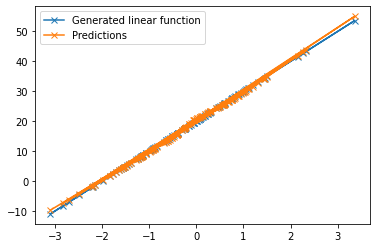

In [15]:
def forward(params, x):
    """Forward pass for the MLP
    
    Args:
        params: A pytree containing the parameters of the network
        x: Inputs
    """
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']


def loss_fn(params, x, y):
    """Mean squared error loss function."""
    return jnp.mean((forward(params, x) - y) ** 2)



@jax.jit
def update(params, x, y):
    """Updates the parameters of the network.
    
    Args:
        params: A pytree containing the parameters of the network
        x : Inputs
        y:  Outputs
    Returns:
        Pytree with updated values
    """
    
    # 1. Calculate the gradients based on the loss
    grads = jax.grad(loss_fn)(params, x, y)
    
    # 2. Update the parameters using `tree_multi_map(...)`
    return jax.tree_multimap(lambda p, g: p - 0.0001 * g, params, grads)




# Run the model for a few iterations
for _ in range(2000):
    params = update(params, x, y)
    
    
# Plot the predictions and the ground truth
plt.plot(x, y, marker='x', label='Generated linear function')
plt.plot(x, forward(params, x), marker="x", label="Predictions")
plt.legend()
plt.show()

That's it for now. We have now completed all the basic things you need to know about JAX. I believe if you grasp the understanding of the concepts that we have covered yet, it will be more than sufficient. In future tutorials, we will build NNs using JAX.

# References

1. https://jax.readthedocs.io/en/latest/pytrees.html
2. https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html
3. https://arxiv.org/pdf/2111.00254v1.pdf
4. https://github.com/patrick-kidger/equinox
5. https://github.com/poets-ai/elegy